<a href="https://colab.research.google.com/github/SzymSAS/lecture1/blob/main/PUM5_regresjanieliniowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, RANSACRegressor, TheilSenRegressor, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import PredictionErrorDisplay

In [2]:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Salary Data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "rkiattisak/salaly-prediction-for-beginer",
  file_path,
)

print("First 5 records:", df.head())

<ipython-input-2-9f69f8392d9a>:9: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


100%|██████████| 18.9k/18.9k [00:00<00:00, 17.4MB/s]

First 5 records:     Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


In [3]:
df.info()

le = LabelEncoder()

for column in ['Gender', 'Education Level', 'Job Title']:
  if column in df.columns:
    df[column] = le.fit_transform(df[column])

print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB
    Age  Gender  Education Level  Job Title  Years of Experience    Salary
0  32.0       1                0        159                  5.0   90000.0
1  28.0       0                1         17                  3.0   65000.0
2  45.0       1                2        130                 15.0  150000.0
3  36.0       0                0        101                  7.0   60000.0
4  52.0       1                1         22                 20.0  20

Zbuduj model benchmarkowy - zwykłą regresję liniową

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Podział danych na cechy (X) i zmienną docelową (y)
X = df.drop(columns=['Salary'])
y = df['Salary']

# Remove rows with missing values in X and corresponding rows in y
X = X.dropna()
y = y[X.index]

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = imputer.fit_transform(X_train) # Fit and Transform on the Training data
X_test = imputer.transform(X_test) # Transform the Test data

# Inicjalizacja i trenowanie modelu regresji liniowej
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = linear_model.predict(X_test)

# Ocena modelu
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

MSE: 249075656.4272, MAE: 10928.9215, R2: 0.8961


Sprawdź czy w danych występuje współliniowość współczynnikiem VIF

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Obliczanie VIF dla każdej zmiennej niezależnej
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Feature        VIF
0                  Age  15.191310
1               Gender   2.059767
2      Education Level   2.403316
3            Job Title   4.865563
4  Years of Experience   9.479247


Spróbuj poprawić wynik używając regresji LASSO

In [9]:
from sklearn.linear_model import Lasso

# Inicjalizacja i trenowanie modelu LASSO z regularyzacją (alfa określa siłę regularyzacji)
lasso_model = Lasso(alpha=100)  # Możesz dostosować wartość alpha

lasso_model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_lasso = lasso_model.predict(X_test)

# Ocena modelu
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'LASSO - MSE: {mse_lasso:.4f}, MAE: {mae_lasso:.4f}, R2: {r2_lasso:.4f}')

LASSO - MSE: 249060331.3467, MAE: 10888.5245, R2: 0.8961


Zbuduj dodatkową zmienną, kwadrat lat doświadczenia, zbuduj ponownie regresję


In [10]:
# Dodanie nowej cechy - kwadrat lat doświadczenia
df["Years of Experience²"] = df["Years of Experience"] ** 2

# Podział na cechy i zmienną docelową
X = df.drop(columns=['Salary'])
y = df['Salary']

# Usunięcie brakujących wartości
X = X.dropna()
y = y[X.index]

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie danych (opcjonalnie, jeśli modele tego wymagają)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu regresji liniowej
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predykcja
y_pred = linear_model.predict(X_test)

# Ocena modelu
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}')

MSE: 253103319.0019, MAE: 10898.0107, R2: 0.8944


narysyj wykres typu scatterplot, dla zmiennych lata doswiadczenia i płaca, czy regresja wyższego rzędu jest uzasadniona?

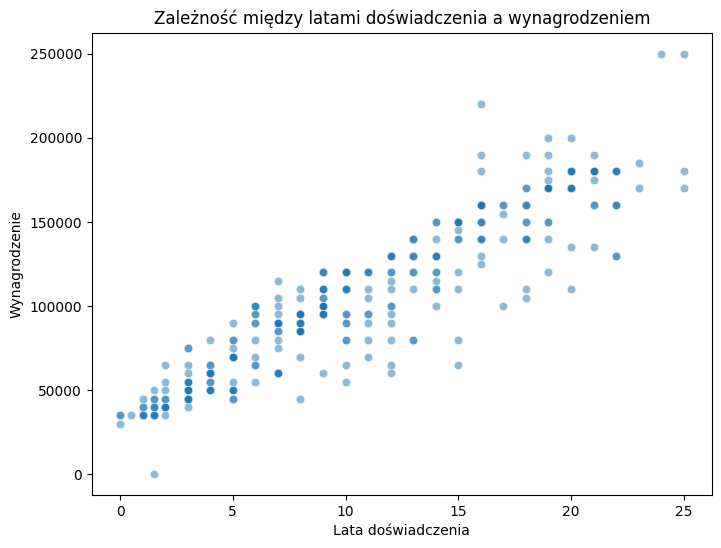

In [13]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Years of Experience"], y=df["Salary"], alpha=0.5)
plt.xlabel("Lata doświadczenia")
plt.ylabel("Wynagrodzenie")
plt.title("Zależność między latami doświadczenia a wynagrodzeniem")
plt.show()

Spróbuj wykorzystać regresje za pomocą K-NN
https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html#sphx-glr-auto-examples-neighbors-plot-regression-py

In [12]:
from sklearn.neighbors import KNeighborsRegressor

# Inicjalizacja modelu K-NN (wybierz liczbę sąsiadów)
knn_model = KNeighborsRegressor(n_neighbors=5)  # Możesz dostosować n_neighbors

# Trenowanie modelu
knn_model.fit(X_train, y_train)

# Predykcja
y_pred_knn = knn_model.predict(X_test)

# Ocena modelu
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f'K-NN - MSE: {mse_knn:.4f}, MAE: {mae_knn:.4f}, R2: {r2_knn:.4f}')

K-NN - MSE: 262979798.6667, MAE: 10532.4000, R2: 0.8903
